In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import gc
import glob
import imageio.v2
import os
from IPython import display
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import matplotlib.patheffects as PathEffects
from global_land_mask import globe

In [2]:
path = '/glade/work/noteng/masters-research/data/lwc_precip_rate/'
data = 'lwe_precip_rate-march13-march14.nc'
ds = xr.open_dataset(path+data, engine='netcdf4')
# selecting the radar precipitation variable
ds1 = ds.sel(time=slice('2020-03-13T04:00:00.000000000', '2020-03-14T00:00:00.000000000'))
lwe_precip_rate = ds1['lwe_precipitation_rate']
lwe_precip_rate

<xarray.DataArray 'lwe_precipitation_rate' (time: 21, Yc: 1869, Xc: 1554)>
[60992946 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2020-03-13T04:00:00 ... 2020-03-14
  * Xc       (Xc) float32 -2.95e+05 -2.94e+05 -2.93e+05 ... 1.257e+06 1.258e+06
  * Yc       (Yc) float32 8.124e+06 8.123e+06 8.122e+06 ... 6.257e+06 6.256e+06
    lon      (Yc, Xc) float32 ...
    lat      (Yc, Xc) float32 ...
Attributes:
    standard_name:  lwe_precipitation_rate
    long_name:      Radar Precipitation Rate
    units:          mm/h
    grid_mapping:   projection_utm

In [3]:
# # Resample data and sum the precipitation data along the time dimension
sum_lwe_precip_rate = lwe_precip_rate.resample(time='1H').sum(dim=['time']) # units in mm/hr
sum_all_lwe_precip_rate = lwe_precip_rate.sum(dim='time') # units in mm

In [4]:
np.max(sum_all_lwe_precip_rate.data), np.mean(sum_all_lwe_precip_rate.data)

(283.09042, 0.4653309)

In [5]:
sum_all_lwe_precip_rate

<xarray.DataArray 'lwe_precipitation_rate' (Yc: 1869, Xc: 1554)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * Xc       (Xc) float32 -2.95e+05 -2.94e+05 -2.93e+05 ... 1.257e+06 1.258e+06
  * Yc       (Yc) float32 8.124e+06 8.123e+06 8.122e+06 ... 6.257e+06 6.256e+06
    lon      (Yc, Xc) float32 ...
    lat      (Yc, Xc) float32 ...

In [6]:
sum_all_lwe_precip_rate1 = globe.is_land(sum_all_lwe_precip_rate['lat'], sum_all_lwe_precip_rate['lon'])
sum_all_lwe_precip_rate1

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [7]:
sum_all_lwe_precip_rate = sum_all_lwe_precip_rate.where(sum_all_lwe_precip_rate1, other=0)
sum_all_lwe_precip_rate

<xarray.DataArray 'lwe_precipitation_rate' (Yc: 1869, Xc: 1554)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * Xc       (Xc) float32 -2.95e+05 -2.94e+05 -2.93e+05 ... 1.257e+06 1.258e+06
  * Yc       (Yc) float32 8.124e+06 8.123e+06 8.122e+06 ... 6.257e+06 6.256e+06
    lon      (Yc, Xc) float32 -8.336 -8.31 -8.284 -8.257 ... 27.11 27.12 27.14
    lat      (Yc, Xc) float32 71.81 71.81 71.82 71.82 ... 55.85 55.85 55.85

CPU times: user 20.5 s, sys: 330 ms, total: 20.8 s
Wall time: 21.9 s


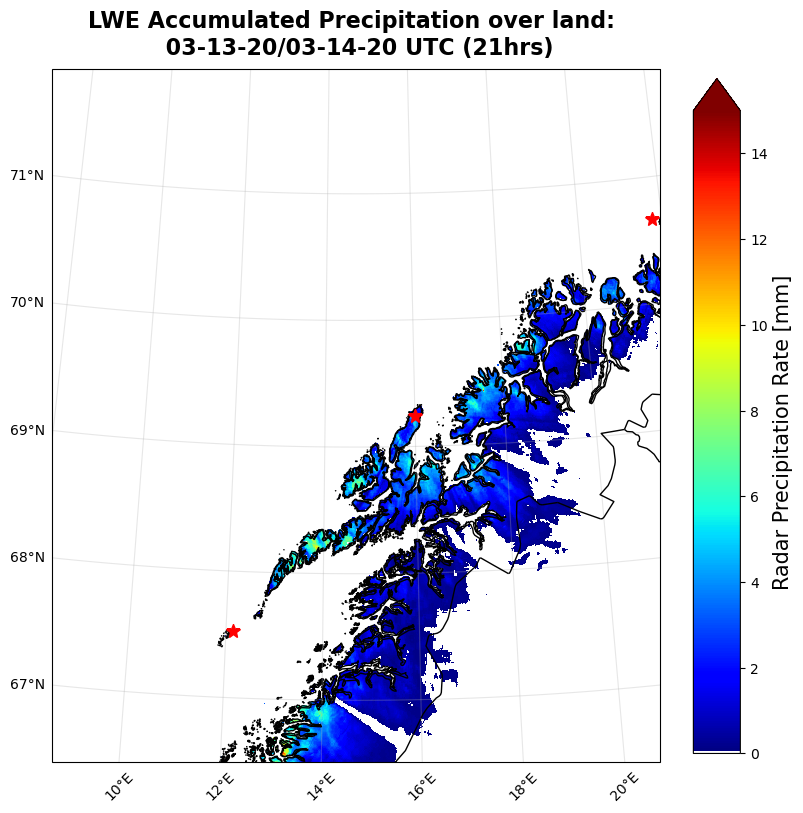

In [8]:
%%time
latA = 69.141281  # latitude of COMBLE site
lonA = 15.684166-1  # longitude of COMBLE site -1
xm, ym = 6, 2.75  # extent from center point in lon and lat


fig, ax = plt.subplots(figsize=(10, 9), subplot_kw={
                           'projection': ccrs.Orthographic(lonA, latA)})
ax.set_facecolor("xkcd:white")
# set extent
extent = [lonA-xm, lonA+xm, latA-ym, latA+ym]
ax.set_extent(extent)  # set extent of map

# ax.outline_patch.set_edgecolor('black')

# plotting coastlines at a very high resolution: 10m
ax.coastlines(resolution='10m', zorder=7)
# add borders
ax.add_feature(cfeature.BORDERS, zorder=7)
# add land
# ax.add_feature(cfeature.LAND, linewidth=1.5, alpha=0, zorder=7)
# add land
# ax.add_feature(cfeature.OCEAN, linewidth=1.5, alpha=0.3, zorder=2)
# add grid lines
gl = ax.gridlines(x_inline=False, alpha=0.3)
gl.bottom_labels=True
gl.left_labels=True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'rotation': 45, 'color': 'black'}
gl.ylabel_style = {'color': 'black'} 
# add terrain
ax.add_feature(cfeature.GSHHSFeature(scale='high'))



# Radar locations
ax.plot(16.00297, 69.24139, color='red', marker='*', markersize=10.5,
        transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location of Radar Andoya
ax.plot(12.1544, 67.5264, color='red', marker='*', markersize=10.5,
        transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location at SW
ax.plot(21.7544, 70.664, color='red', marker='*', markersize=10.5,
        transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location at NE


# # Create the 'jet' colormap
cmap = plt.get_cmap('jet')
# # Modify the colormap
colors = cmap(np.arange(cmap.N))
colors[0] = np.array([1.0, 1.0, 1.0, 1.0])  # change the first color to white
new_cmap = mcolors.LinearSegmentedColormap.from_list("new_jet", colors)

  

# # OVERLAY RADAR PRECIPITATION RATE DATA OVER PROJECTION

# # change time to moth, day, year, hours and minutes
# dt = sum_lwe_precip_rate['time'].dt.strftime('%m-%d-%Y %H:%M').values  # array
norm = Normalize(vmin=0, vmax=15)
cmap = 'Blues'
cs = ax.pcolormesh(sum_all_lwe_precip_rate['lon'], 
                   sum_all_lwe_precip_rate['lat'], 
                   sum_all_lwe_precip_rate,
                   transform=ccrs.PlateCarree(),
                   cmap=new_cmap,
                   norm=norm
                  )

# Create the box around the text
# bbox = dict(facecolor='white', edgecolor='black', boxstyle='round')
# path_effects = [PathEffects.withStroke(linewidth=1.5, foreground='w')]

# Add the text and the box to the plot
# latA1 = 71.53; lonA1 = 7.3 
# ax.text(lonA1, latA1, f'Radar to <~100km\n90th percentile={np.nanpercentile(sum_all_lwe_precip_rate1.data, 90):.1f} mm\nmean={np.nanmean(sum_all_lwe_precip_rate1.data):.1f} mm', 
#         transform=ccrs.PlateCarree(), color='black', fontsize=10,  bbox=bbox, path_effects=path_effects)


ax.set_title(
        f"LWE Accumulated Precipitation over land: \n 03-13-20/03-14-20 UTC (21hrs)", fontweight='bold', fontsize=16, pad=11)

# # # Add a colorbar axis at the right of the graph
cbar_ax = fig.add_axes([0.85, 0.12, 0.047, 0.75])  # lbwh

cbar = fig.colorbar(cs, cax=cbar_ax, orientation='vertical', extend='max')
cbar.set_label("Radar Precipitation Rate [mm]", fontsize=15)

    

fig.savefig('try-rate-13th-14th-March.png', bbox_inches='tight',dpi=500)